In [26]:
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm

In [27]:
import cv2

def cxcywh2xyxy(x):
    y = x.clone() if isinstance(x, torch.Tensor) else np.copy(x)
    y[..., 0] = x[..., 0] - x[..., 2]/2  # x center
    y[..., 1] = x[..., 1] - x[..., 3]/2  # y center
    y[..., 2] = x[..., 0] + x[..., 2]/2  # width
    y[..., 3] = x[..., 1] + x[..., 3]/2  # height
    return y

In [28]:
imagesPath = "*RPC/test/images/*.png"
labelsPath = "*RPC/test/labels/*.txt"
SupportPath = "RPC/support/images/"
best = 'runs/oneshot/yolov8n_RPC/weights/best.pt'

# imagesPath = "*COCO1/valid/images/*.png"
# labelsPath = "*COCO1/valid/labels/*.txt"
# SupportPath = "COCO1/support/images/"
# best = 'runs/oneshot/yolov8n_COCO1__support0/weights/best.pt'

In [29]:
import glob
filesName =  glob.glob(imagesPath)
filesName.sort()
labelsName = glob.glob(labelsPath)
labelsName.sort()
print(len(filesName))
print(len(labelsName))

37655
37655


In [30]:
from ultralytics import YOLO
from PIL import Image

model = YOLO(best)  # load a pretrained YOLOv8n model

In [31]:
true_labels = {}
predictions = {}
# i = 0

for f,l in tqdm(zip(filesName,labelsName), total=len(filesName)):
    name = f.split('.')[0]
    classe = f.split('.')[1]

    image = Image.open(f)
    image = np.asarray(image)
    support = Image.open(SupportPath+classe+'.png')
    support = np.asarray(support)

    #convert GrayImage to RGB Image:
    if(len(image.shape) == 2):
        image = np.stack((image,)*3, axis=-1)

    results = model.predict(source=image, support=support, verbose=False)  # predict on an image

    bboxes = results[0].boxes.data.cpu().numpy()
    if bboxes.ndim == 1:
        bboxes = np.array([bboxes])
    bboxes[:,5] = int(f.split('.')[1])
    bboxes[:,:4] = bboxes[:,:4]/results[0].orig_img.shape[0]

    label = np.loadtxt(l)
    if label.ndim == 1:
        label = np.array([label])
    label[:,0] = int(f.split('.')[1])

    label[:,1:5] = cxcywh2xyxy(label[:,1:5])

    if classe not in true_labels.keys():
        predictions[classe] = {name:np.array(bboxes)}
        true_labels[classe] = {name:np.array(label)}
    else:
        if name not in predictions[classe]:
            predictions[classe][name] = np.array(bboxes)
            true_labels[classe][name] = np.array(label)
        if len(bboxes) != 0:
           predictions[classe][name] = np.concatenate((predictions[classe][name],bboxes),0)
        true_labels[classe][name] = np.concatenate((true_labels[classe][name],label),0)

100%|██████████| 37655/37655 [14:34<00:00, 43.04it/s]


In [32]:
from __future__ import absolute_import, division, print_function

from copy import deepcopy
import json
import glob
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_style('white')
sns.set_context('poster')

COLORS = [
    '#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c',
    '#98df8a', '#d62728', '#ff9896', '#9467bd', '#c5b0d5',
    '#8c564b', '#c49c94', '#e377c2', '#f7b6d2', '#7f7f7f',
    '#c7c7c7', '#bcbd22', '#dbdb8d', '#17becf', '#9edae5']


def calc_iou_individual(pred_box, gt_box):
    """Calculate IoU of single predicted and ground truth box
    Args:
        pred_box (list of floats): location of predicted object as
            [xmin, ymin, xmax, ymax]
        gt_box (list of floats): location of ground truth object as
            [xmin, ymin, xmax, ymax]
    Returns:
        float: value of the IoU for the two boxes.
    Raises:
        AssertionError: if the box is obviously malformed
    """
    c, x1_t, y1_t, x2_t, y2_t = gt_box
    x1_p, y1_p, x2_p, y2_p = pred_box

    if (x1_p > x2_p) or (y1_p > y2_p):
        raise AssertionError(
            "Prediction box is malformed? pred box: {}".format(pred_box))
    if (x1_t > x2_t) or (y1_t > y2_t):
        raise AssertionError(
            "Ground Truth box is malformed? true box: {}".format(gt_box))

    if (x2_t < x1_p or x2_p < x1_t or y2_t < y1_p or y2_p < y1_t):
        return 0.0

    far_x = np.min([x2_t, x2_p])
    near_x = np.max([x1_t, x1_p])
    far_y = np.min([y2_t, y2_p])
    near_y = np.max([y1_t, y1_p])

    inter_area = (far_x - near_x + 1) * (far_y - near_y + 1)
    true_box_area = (x2_t - x1_t + 1) * (y2_t - y1_t + 1)
    pred_box_area = (x2_p - x1_p + 1) * (y2_p - y1_p + 1)
    iou = inter_area / (true_box_area + pred_box_area - inter_area)
    return iou

def box_iou(box1, box2, eps=1e-7):
    """
    Calculate intersection-over-union (IoU) of boxes.
    Both sets of boxes are expected to be in (x1, y1, x2, y2) format.
    Based on https://github.com/pytorch/vision/blob/master/torchvision/ops/boxes.py
    """

    (a1, a2), (b1, b2) = box1.unsqueeze(1).chunk(2, 2), box2.unsqueeze(0).chunk(2, 2)
    inter = (torch.min(a2, b2) - torch.max(a1, b1)).clamp_(0).prod(2)

    # IoU = inter / (area1 + area2 - inter)
    return inter / ((a2 - a1).prod(2) + (b2 - b1).prod(2) - inter + eps)

def get_single_image_results(gt_boxes, pred_boxes, iou_thr):
    """Calculates number of true_pos, false_pos, false_neg from single batch of boxes.
    Args:
        gt_boxes (list of list of floats): list of locations of ground truth
            objects as [xmin, ymin, xmax, ymax]
        pred_boxes (dict): dict of dicts of 'boxes' (formatted like `gt_boxes`)
            and 'scores'
        iou_thr (float): value of IoU to consider as threshold for a
            true prediction.
    Returns:
        dict: true positives (int), false positives (int), false negatives (int)
    """

    all_pred_indices = range(len(pred_boxes))
    all_gt_indices = range(len(gt_boxes))
    if len(all_pred_indices) == 0:
        tp = 0
        fp = 0
        fn = len(gt_boxes)
        return {'true_pos': tp, 'false_pos': fp, 'false_neg': fn}
    if len(all_gt_indices) == 0:
        tp = 0
        fp = len(pred_boxes)
        fn = 0
        return {'true_pos': tp, 'false_pos': fp, 'false_neg': fn}

    gt_idx_thr = []
    pred_idx_thr = []
    ious = []
    for ipb, pred_box in enumerate(pred_boxes):
        for igb, gt_box in enumerate(gt_boxes):
            iou = calc_iou_individual(pred_box, gt_box)
            if iou > iou_thr:
                gt_idx_thr.append(igb)
                pred_idx_thr.append(ipb)
                ious.append(iou)

    args_desc = np.argsort(ious)[::-1]
    if len(args_desc) == 0:
        # No matches
        tp = 0
        fp = len(pred_boxes)
        fn = len(gt_boxes)
    else:
        gt_match_idx = []
        pred_match_idx = []
        for idx in args_desc:
            gt_idx = gt_idx_thr[idx]
            pr_idx = pred_idx_thr[idx]
            # If the boxes are unmatched, add them to matches
            if (gt_idx not in gt_match_idx) and (pr_idx not in pred_match_idx):
                gt_match_idx.append(gt_idx)
                pred_match_idx.append(pr_idx)
        tp = len(gt_match_idx)
        fp = len(pred_boxes) - len(pred_match_idx)
        fn = len(gt_boxes) - len(gt_match_idx)

    return {'true_pos': tp, 'false_pos': fp, 'false_neg': fn}

def calc_precision_recall(img_results):
    """Calculates precision and recall from the set of images
    Args:
        img_results (dict): dictionary formatted like:
            {
                'img_id1': {'true_pos': int, 'false_pos': int, 'false_neg': int},
                'img_id2': ...
                ...
            }
    Returns:
        tuple: of floats of (precision, recall)
    """
    true_pos = 0; false_pos = 0; false_neg = 0
    for _, res in img_results.items():
        true_pos += res['true_pos']
        false_pos += res['false_pos']
        false_neg += res['false_neg']

    try:
        precision = true_pos/(true_pos + false_pos)
    except ZeroDivisionError:
        precision = 0.0
    try:
        recall = true_pos/(true_pos + false_neg)
    except ZeroDivisionError:
        recall = 0.0

    return (precision, recall)

def get_model_scores_map(pred_boxes):
    """Creates a dictionary of from model_scores to image ids.
    Args:
        pred_boxes (dict): dict of dicts of 'boxes' and 'scores'
    Returns:
        dict: keys are model_scores and values are image ids (usually filenames)
    """
    model_scores_map = {}
    for img_id, val in pred_boxes.items():
        if len(val) == 0:
            continue
        for score in val[:,4]:
            if score not in model_scores_map.keys():
                model_scores_map[score] = [img_id]
            else:
                model_scores_map[score].append(img_id)
    return model_scores_map

def get_avg_precision_at_iou(gt_boxes, pred_boxes, iou_thr=0.5):
    """Calculates average precision at given IoU threshold.
    Args:
        gt_boxes (list of list of floats): list of locations of ground truth
            objects as [xmin, ymin, xmax, ymax]
        pred_boxes (list of list of floats): list of locations of predicted
            objects as [xmin, ymin, xmax, ymax]
        iou_thr (float): value of IoU to consider as threshold for a
            true prediction.
    Returns:
        dict: avg precision as well as summary info about the PR curve
        Keys:
            'avg_prec' (float): average precision for this IoU threshold
            'precisions' (list of floats): precision value for the given
                model_threshold
            'recall' (list of floats): recall value for given
                model_threshold
            'models_thrs' (list of floats): model threshold value that
                precision and recall were computed for.
    """
    model_scores_map = get_model_scores_map(pred_boxes)
    sorted_model_scores = sorted(model_scores_map.keys())

    # Sort the predicted boxes in descending order (lowest scoring boxes first):
    for img_id in pred_boxes.keys():
        arg_sort = np.argsort(pred_boxes[img_id][:,4])
        if(len(pred_boxes[img_id]) == 0):
            continue
        pred_boxes[img_id] = np.array(pred_boxes[img_id][arg_sort])

    pred_boxes_pruned = deepcopy(pred_boxes)

    precisions = []
    recalls = []
    model_thrs = []
    img_results = {}
    # Loop over model score thresholds and calculate precision, recall
    for ithr, model_score_thr in enumerate(sorted_model_scores[:-1]):
        # On first iteration, define img_results for the first time:
        img_ids = gt_boxes.keys() if ithr == 0 else model_scores_map[model_score_thr]
        for img_id in img_ids:
            gt_boxes_img = gt_boxes[img_id]
            box_scores = pred_boxes_pruned[img_id][:,4]
            start_idx = 0
            for score in box_scores:
                if score <= model_score_thr:
                    pred_boxes_pruned[img_id]
                    start_idx += 1
                else:
                    break

            # Remove boxes, scores of lower than threshold scores:
            pred_boxes_pruned[img_id] =  np.array(pred_boxes_pruned[img_id][start_idx:])

            # Recalculate image results for this image
            img_results[img_id] = get_single_image_results(
                gt_boxes_img, pred_boxes_pruned[img_id][:,:4], iou_thr)

        prec, rec = calc_precision_recall(img_results)
        precisions.append(prec)
        recalls.append(rec)
        model_thrs.append(model_score_thr)

    precisions = np.array(precisions)
    recalls = np.array(recalls)
    prec_at_rec = []
    for recall_level in np.linspace(0.0, 1.0, 11):
        try:
            args = np.argwhere(recalls >= recall_level).flatten()
            prec = max(precisions[args])
        except ValueError:
            prec = 0.0
        prec_at_rec.append(prec)
    avg_prec = np.mean(prec_at_rec)

    return {
        'avg_prec': avg_prec,
        'precisions': precisions,
        'recalls': recalls,
        'model_thrs': model_thrs}



In [33]:
gt_boxes = true_labels
pred_boxes = predictions

liste = {}

# Runs it for one IoU threshold
iou_thr = 0.5

for c in gt_boxes.keys():
    start_time = time.time()
    data = get_avg_precision_at_iou(true_labels[c], predictions[c], iou_thr=iou_thr)
    end_time = time.time()
    print("classe "+str(c))
    print('Single IoU calculation took {:.4f} secs'.format(end_time - start_time))
    print('avg precision: {:.4f}'.format(data['avg_prec']))
    liste[c] = data['avg_prec']

classe 131
Single IoU calculation took 0.0102 secs
avg precision: 0.0202
classe 100
Single IoU calculation took 0.0652 secs
avg precision: 0.1229
classe 45
Single IoU calculation took 0.3460 secs
avg precision: 0.1878
classe 130
Single IoU calculation took 0.1224 secs
avg precision: 0.0251
classe 94
Single IoU calculation took 0.0099 secs
avg precision: 0.0327
classe 124
Single IoU calculation took 0.0059 secs
avg precision: 0.0909
classe 57
Single IoU calculation took 0.7287 secs
avg precision: 0.7431
classe 62
Single IoU calculation took 0.0487 secs
avg precision: 0.1693
classe 170
Single IoU calculation took 0.0303 secs
avg precision: 0.0818
classe 99
Single IoU calculation took 0.3934 secs
avg precision: 0.7170
classe 116
Single IoU calculation took 0.0168 secs
avg precision: 0.0376
classe 183
Single IoU calculation took 0.1384 secs
avg precision: 0.4741
classe 89
Single IoU calculation took 0.1599 secs
avg precision: 0.2559
classe 12
Single IoU calculation took 0.9782 secs
avg pre

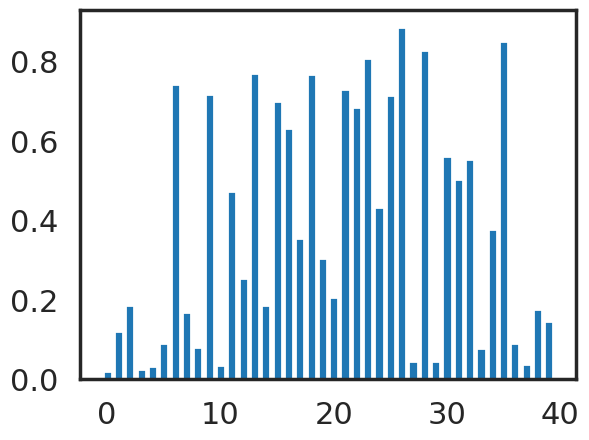

In [44]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(0,len(liste.keys()))
y = liste.values()

plt.bar(x,y)
plt.show()


In [47]:
np.mean(list(y))

0.3863664274537153